Se comienza importando las librerias a utilizar y, posteriormente, se realiza una revisión inicial de los datos.

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import geopandas as gpd
import folium
import plotly.express as px
from shapely.geometry import Point
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [50]:
# Configuración general
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Carga de datos
file_path = "BD_Tlaxcala_RETO.xlsx"
base = pd.read_excel(file_path, sheet_name="Tlaxcala_Filtrado")

In [51]:
# Información general y limpieza
print("Info general:")
print(base.info())
print("\nValores nulos:")
print(base.isnull().sum().sort_values(ascending=False))


Info general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82801 entries, 0 to 82800
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lat          82801 non-null  float64
 1   long         82801 non-null  float64
 2   nombre_act   82801 non-null  object 
 3   fuente       82801 non-null  object 
 4   id           82801 non-null  int64  
 5   nom_estab    82800 non-null  object 
 6   per_ocu      82801 non-null  object 
 7   tipo_vial    82438 non-null  object 
 8   nom_vial     82801 non-null  object 
 9   tipo_asent   82587 non-null  object 
 10  cod_postal   81521 non-null  float64
 11  entidad      82801 non-null  object 
 12  municipio    82801 non-null  object 
 13  localidad    82801 non-null  object 
 14  tipoUniEco   82801 non-null  object 
 15  fecha_alta   82801 non-null  object 
 16  Tam_negocio  82801 non-null  object 
dtypes: float64(3), int64(1), object(13)
memory usage: 10.7+ MB
None

Valores n

In [52]:
#La siguiente función se utiliza para limpiar las letras que anteriormente tenían acento y se modifican al momento de pasarlos a excel

def limpiar_caracteres(texto):
    if isinstance(texto, str):
        reemplazos = {
            "√≠": "í",
            "√≥": "ó",
            "√©": "é",
            "√í": "á",
            "√≤": "ó",
            "√ú": "ú",
            "√±": "ñ",
            "√ü": "ü",
            "√É": "É",
            "√å": "à",
            "√Å": "Á",
            "√á": "í",
            "√ã": "é",
            "√°": "á",
            "É¬°": "á"
        }
        for corrupto, correcto in reemplazos.items():
            texto = texto.replace(corrupto, correcto)
    return texto

# Aplicarlo a todo el DataFrame
df = base.applymap(limpiar_caracteres)

C:\Users\estra\AppData\Local\Temp\ipykernel_2612\3268122809.py:27: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [53]:
# Cambio los valores de codigo postal a enteros

df["cod_postal"] = df["cod_postal"].fillna(0).astype(int).astype(str)

Análisis EDA de los datos

In [54]:
# Conteo de negocios por municipio

negocios_por_municipio = df["municipio"].value_counts().head(10)
print("Negocios por municipio:")
print(negocios_por_municipio)

Negocios por municipio:
municipio
Tlaxcala                            8262
Apizaco                             8188
Chiautempan                         6954
Huamantla                           5717
San Pablo del Monte                 5501
Zacatelco                           3903
Calpulalpan                         3341
Contla de Juan Cuamatzi             2485
Papalotla de Xicohténcatl           2156
Ixtacuixtla de Mariano Matamoros    1941
Name: count, dtype: int64


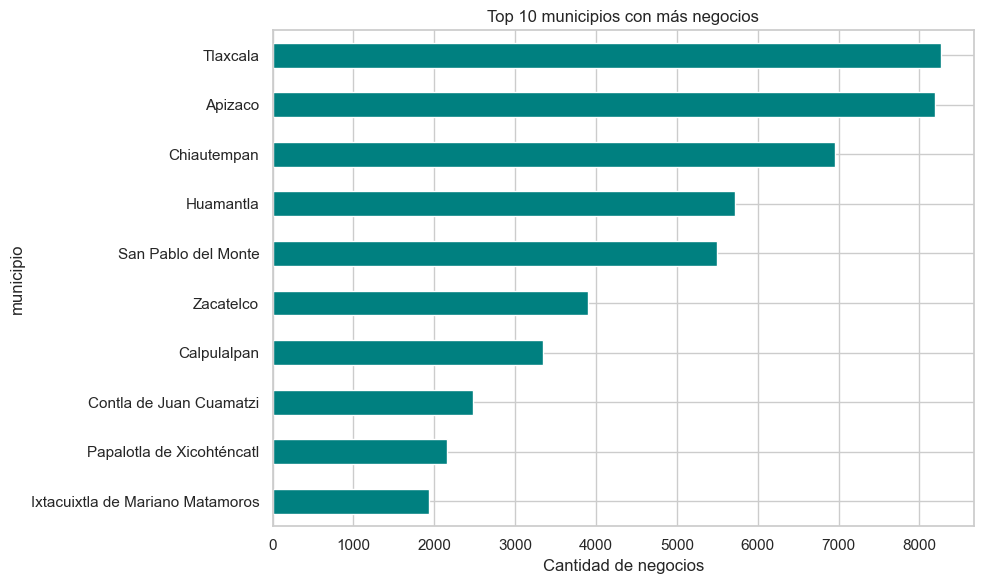

In [55]:
plt.figure(figsize=(10, 6))
negocios_por_municipio.head(10).plot(kind='barh', color='teal')
plt.title("Top 10 municipios con más negocios")
plt.xlabel("Cantidad de negocios")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [56]:
# Conteo de negocios por código postal

negocios_por_cp = df["cod_postal"].value_counts().head(10)
print("\nNegocios por código postal:")
print(negocios_por_cp)


Negocios por código postal:
cod_postal
90300    4201
90800    3042
90500    2935
90740    2794
90000    2268
90250    1710
90670    1661
90460    1627
90970    1545
90790    1472
Name: count, dtype: int64


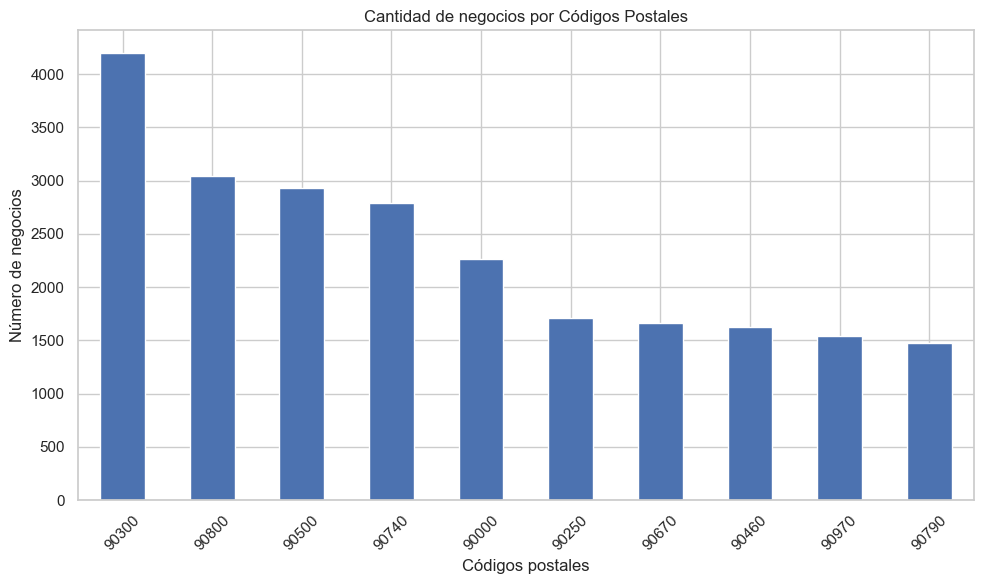

In [57]:
negocios_por_cp.plot(kind="bar", title="Cantidad de negocios por Códigos Postales")
plt.ylabel("Número de negocios")
plt.xlabel("Códigos postales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [58]:
# Conteo de negocios por actividad económica

negocios_por_cp = df["cod_postal"].value_counts().head(10)
print("\nNegocios por código postal:")
print(negocios_por_cp)


Negocios por código postal:
cod_postal
90300    4201
90800    3042
90500    2935
90740    2794
90000    2268
90250    1710
90670    1661
90460    1627
90970    1545
90790    1472
Name: count, dtype: int64


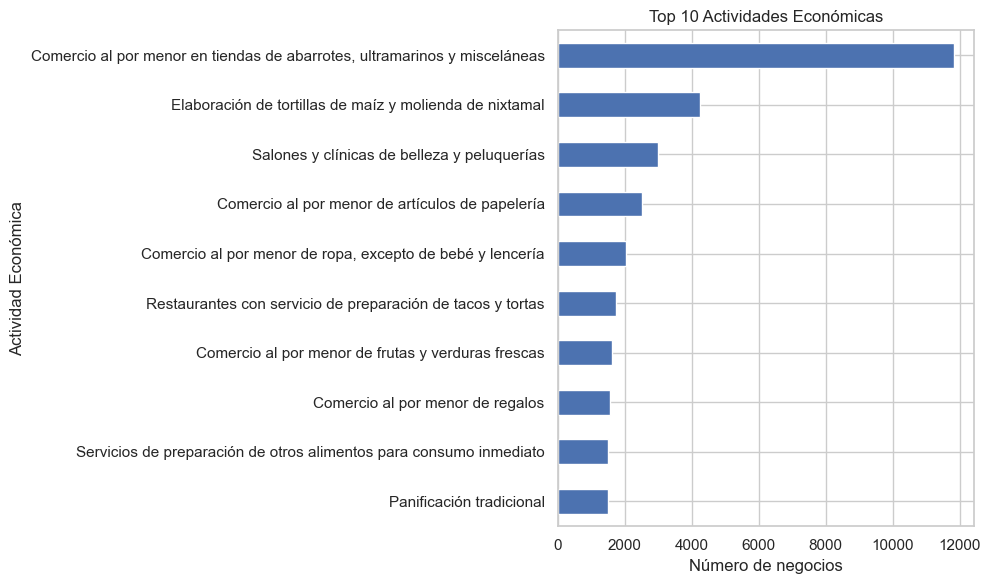

In [59]:
df["nombre_act"].value_counts().head(10).plot(kind="barh", title="Top 10 Actividades Económicas")
plt.xlabel("Número de negocios")
plt.gca().invert_yaxis()
plt.ylabel("Actividad Económica")
plt.tight_layout()
plt.show()

In [60]:
#Conteo de negocios por tamaño
print("\nTamaños de negocio:")
print(df["Tam_negocio"].value_counts())


Tamaños de negocio:
Tam_negocio
Chico      81826
Mediano      701
Grande       271
ND             3
Name: count, dtype: int64


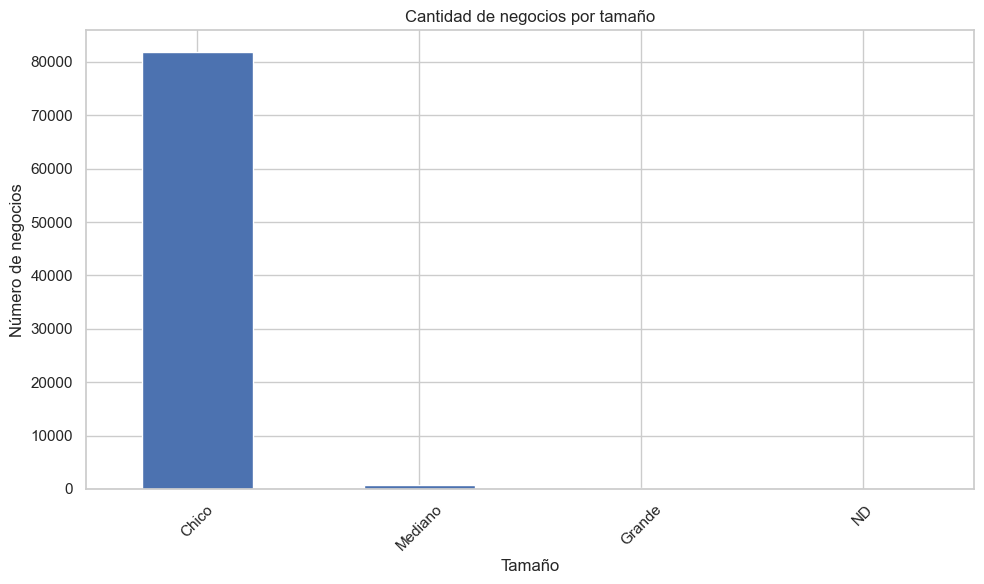

In [61]:
df["Tam_negocio"].value_counts().plot(kind="bar", title="Cantidad de negocios por tamaño")
plt.ylabel("Número de negocios")
plt.xlabel("Tamaño")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

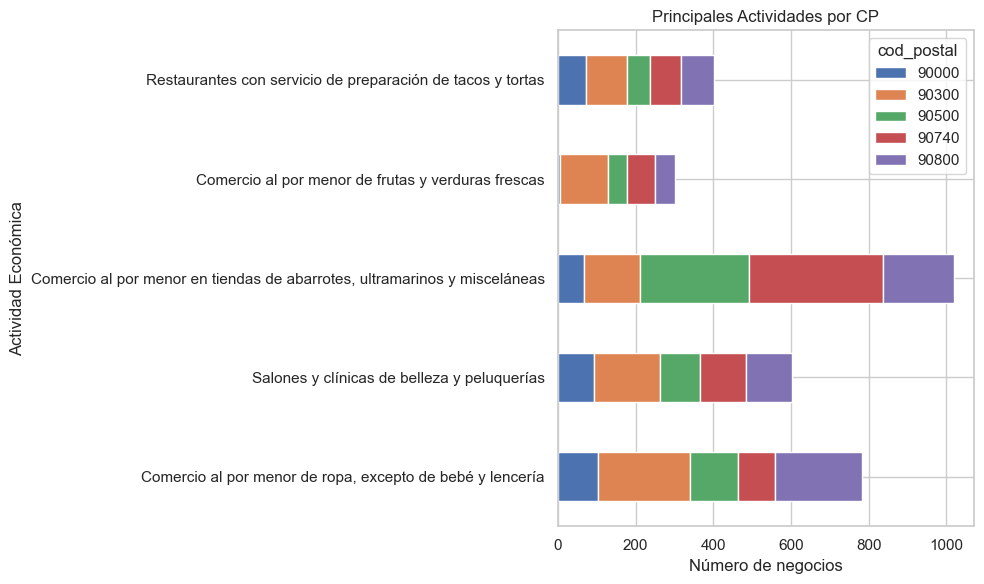

In [71]:
# Principales actividades económicas por codigo postal con mayor densidad
top_cp = negocios_por_cp.index[:5]
df_cp = df[df["cod_postal"].isin(top_cp)]
actividad_cp = df_cp.groupby(["cod_postal", "nombre_act"]).size().unstack().fillna(0)

actividad_cp.T.nlargest(5, top_cp[0]).plot(kind="barh", stacked=True, title="Principales Actividades por CP")
plt.ylabel("Actividad Económica")
plt.xlabel("Número de negocios")
plt.tight_layout()
plt.show()




In [63]:
# Diccionario de mapeo ordinal
mapeo_ocupacion = {
    "0 a 5 personas": 1,
    "6 a 10 personas": 2,
    "11 a 30 personas": 3,
    "31 a 50 personas": 4,
    "51 a 100 personas": 5,
    "101 a 250 personas": 6,
    "251 y más personas": 7
}

# Creo una nueva columna con los valores categóricos ordinales
df["per_ocu_cat"] = df["per_ocu"].map(mapeo_ocupacion)

# Sumo el total de personas por categoría
suma_por_categoria_map = df.groupby("per_ocu")["per_ocu_cat"].value_counts().sort_values(ascending=False)

# Mostrar resultados
print(suma_por_categoria_map)

per_ocu             per_ocu_cat
0 a 5 personas      1              76412
6 a 10 personas     2               3266
11 a 30 personas    3               2148
31 a 50 personas    4                423
51 a 100 personas   5                278
101 a 250 personas  6                173
251 y más personas  7                101
Name: count, dtype: int64


In [65]:
# Filtrar solo los tamaños relevantes
tam_filtrados = ["Chico", "Mediano", "Grande"]

# Crear tabla cruzada (contingencia)
tabla_conteo = pd.crosstab(
    df[df["Tam_negocio"].isin(tam_filtrados)]["per_ocu"],
    df[df["Tam_negocio"].isin(tam_filtrados)]["Tam_negocio"]
).reindex(mapeo_ocupacion.keys())

# Mostrar tabla ordenada por número de personas
print(tabla_conteo)

Tam_negocio         Chico  Grande  Mediano
per_ocu                                   
0 a 5 personas      76412       0        0
6 a 10 personas      3266       0        0
11 a 30 personas     2148       0        0
31 a 50 personas        0       0      423
51 a 100 personas       0       0      278
101 a 250 personas      0     173        0
251 y más personas      0      98        0


Análisis ANOVA


In [ ]:
# ANOVA: ¿Hay diferencia significativa entre tamaños de negocio?
df_anova = df.dropna(subset=["Tam_negocio", "per_ocu_cat"])
grupo_chico = df_anova[df_anova["Tam_negocio"] == "Chico"]["per_ocu_cat"]
grupo_mediano = df_anova[df_anova["Tam_negocio"] == "Mediano"]["per_ocu_cat"]
grupo_grande = df_anova[df_anova["Tam_negocio"] == "Grande"]["per_ocu_cat"]

# Codificación de categorías a números para pruebas estadísticas
le = LabelEncoder()
df_anova["per_ocu_num"] = le.fit_transform(df_anova["per_ocu_cat"])

anova_result = stats.f_oneway(grupo_chico, grupo_mediano, grupo_grande)
print("\nANOVA - Diferencia entre tamaños:")
print("F:", round(anova_result.statistic, 4), "| p-valor:", round(anova_result.pvalue, 4))


ANOVA - Diferencia entre tamaños:
F: 54549.9702 | p-valor: 0.0


Agrupación de negocios por clusters

In [68]:
# Filtramos el DataFrame
df_cluster = df.dropna(subset=["lat", "long", "Tam_negocio", "nombre_act"]).copy()

# Codificamos variables categóricas
df_cluster["Tam_num"] = LabelEncoder().fit_transform(df_cluster["Tam_negocio"])
df_cluster["Act_num"] = LabelEncoder().fit_transform(df_cluster["nombre_act"])

# Matriz de características
X = df_cluster[["lat", "long", "Tam_num", "Act_num"]]

# Aplicamos KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X)
df_cluster["Cluster"] = clusters

# Calculamos Silhouette Score
sil_score = silhouette_score(X, clusters)
print("Silhouette Score:", round(sil_score, 4))

Silhouette Score: 0.5691


In [76]:
# Asegura que el Cluster sea de tipo string para mejor visualización
df_cluster["Cluster"] = df_cluster["Cluster"].astype(str)

# Definir el orden deseado de la leyenda (mayor a menor)
orden_clusters = ["3", "2", "1", "0"]

df_cluster["Cluster"] = pd.Categorical(df_cluster["Cluster"], categories=orden_clusters, ordered=True)

# Centro del mapa
center_lat = df_cluster["lat"].mean()
center_lon = df_cluster["long"].mean()

# Crear el mapa
fig = px.scatter_mapbox(
    df_cluster,
    lat="lat",
    lon="long",
    color="Cluster",
    hover_name="nombre_act",
    zoom=9,
    center={"lat": center_lat, "lon": center_lon},
    title="Segmentación Geoespacial de Negocios por Clúster",
    category_orders={"Cluster": orden_clusters}
)

fig.update_layout(mapbox_style="open-street-map")
fig.write_html("mapa_clusters_tlaxcala.html")
fig.show()


C:\Users\estra\AppData\Local\Temp\ipykernel_2612\1393558467.py:14: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [ ]:
df["geometry"] = df.apply(lambda row: Point(row["long"], row["lat"]), axis=1)
df_geo = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

In [ ]:
# Crear mapa centrado en Tlaxcala
mapa = folium.Map(location=[19.31, -98.24], zoom_start=10)

# Agregar puntos al mapa
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["long"]],
        radius=1,
        color="blue",
        fill=True,
        fill_opacity=0.3,
        popup=row["nombre_act"]
    ).add_to(mapa)

mapa.save("mapa_interactivo.html")

In [ ]:
# Centro del mapa
center_lat = df["lat"].mean()
center_lon = df["long"].mean()

fig = px.scatter_map(
    df,
    lat="lat",
    lon="long",
    color="Tam_negocio",
    hover_name="nombre_act",
    zoom=9,
    center={"lat": center_lat, "lon": center_lon},
    title="Distribución geoespacial de negocios en Tlaxcala"
)

fig.update_layout(mapbox_style="open-street-map")  # Puedes cambiar a otro estilo si deseas
fig.write_html("mapa_tlaxcala_tamaño_negocio.html")

In [ ]:
# Centro del mapa (Tlaxcala)
center_lat = df["lat"].mean()
center_lon = df["long"].mean()

# Crear mapa de calor con plotly.express.density_map
fig = px.density_map(
    df,
    lat="lat",
    lon="long",
    z="per_ocu_cat",
    radius=10,  # Ajusta el nivel de dispersión del calor
    center={"lat": center_lat, "lon": center_lon},
    zoom=9,
    title="Mapa de densidad de negocios en Tlaxcala",
)

# Estilo del mapa (sin necesidad de token)
fig.update_layout(mapbox_style="open-street-map")

# Guardar el mapa en HTML
fig.write_html("mapa_densidad_tlaxcala.html")

In [ ]:
print(df["per_ocu"].unique())